In [1]:
import torch
import matplotlib.pyplot as plt
from fitting import create_ensemble, load_data, create_datasets


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)",
          "z (mm)",r"$\delta\ (10^{-3})$"]

tkwargs = {"dtype": torch.float}
save_dir = "double_small_emittance_case_cov_term_small_energy_spread/"
quad_strengths, image_data, bins, xx, gt_beam = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
cov_trace = torch.stack([ele[1] for ele in traces])



/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get predicted covariances


# iteration number
t = torch.arange(len(cov_trace))

# get gt cov
gt_cov = torch.cov(gt_beam.T)
gt_rms = torch.diag(gt_cov).sqrt()*1e3

trace_rms = torch.diagonal(cov_trace, dim1=-1, dim2=-2).sqrt()*1e3

# calculate learning rate
initial_lr = 0.01
n_models = 20
total_iterations = len(t)
train_period = int(total_iterations / n_models)

lr = 0.5*initial_lr * (torch.cos(3.14*torch.remainder(t-1,train_period) / train_period) + 1.0)
lr = torch.clip(lr, 0.0001)

In [3]:
print(gt_rms)

tensor([4.2426, 2.4037, 5.4557, 2.9660, 2.0000, 1.0000], dtype=torch.float64)


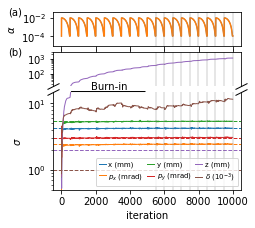

In [5]:
# plot emit_x
import numpy as np

fig,(ax_lr, axb,ax) = plt.subplots(
    3,1, sharex="all",
    gridspec_kw={
        "right": 0.97,"hspace":0.1,"left":0.2,"top":0.975,"bottom":0.15,
        "height_ratios":[0.35,0.35,1.]
    })
fig.set_size_inches(np.array((3.4,3.))*1)
lw=1.0
mean_energy = 1
emit_scale = 1e6
ax_lr.plot(t[::10], lr[::10],lw=lw)
ax_lr.set_yscale("log")
ax_lr.set_ylabel(r"$ \alpha $")
colors = [f"C{i}" for i in range(6)]

ax_lr.plot(t, lr)

for i in range(6):
    ax.semilogy(t[::10], trace_rms[:,i][::10].cpu().detach(), label=labels[i],c=colors[i],lw=1)
    ax.axhline(gt_rms[i].cpu().detach(),ls='--',c=colors[i],lw=lw)
    
axb.semilogy(t[::10], trace_rms[:,-2][::10].cpu().detach(), c=colors[-2],lw=1)

# add locations of snapshots
for ele in t[train_period::train_period-1][10:]:
    for a in [ax_lr, ax,axb]:
        a.axvline(ele, c = "C7",alpha=0.25)
    
ax.set_ylabel("$\sigma$ ")
ax.set_xlabel("iteration")
fontsize = 7
handletextpad = 0.4
ax.legend(ncol=3, handlelength=1.0, columnspacing=0.5, fontsize=fontsize, handletextpad=handletextpad,loc=4)
ax.set_ylim(5e-1, 1.5e1)
axb.set_ylim( 1.5e1, 3e3)

# hformat split axis
axb.spines.bottom.set_visible(False)
ax.spines.top.set_visible(False)
axb.xaxis.tick_top()
axb.tick_params(labeltop=False)  # don't put tick labels at the top
ax.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axb.plot([0, 1], [0, 0], transform=axb.transAxes, **kwargs)
ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)

ax_lr.set_ylim(0.8e-5,5e-2)
letters = "abc"
for a, l in zip((ax_lr,axb),letters):
    a.text(-0.2, 1.0, f"({l})", ha='center',
                       va='center', transform=a.transAxes)

ax.annotate("Burn-in",xy=(0.5,1.0),
            xytext = (0.3,1.0),arrowprops = {"arrowstyle":"-","relpos":(-0.6,0)},
            ha="center",va="bottom",
            xycoords="axes fraction",textcoords="axes fraction")
#ax.annotate("Burn-In", xy = (5000,0.5), xytext=(0,0.5),
#            arrowprops=dict(facecolor='black', shrink=0.05, width=0.1,headwidth=5.0),
#            va="center",
#            )
fig.savefig("convergence.svg")
fig.savefig("convergence.png", dpi=300)


